# Set up Environment

In [1]:
import scanpy as sc
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.5.1 anndata==0.7.3 umap==0.4.4 numpy==1.19.0 scipy==1.5.0 pandas==1.0.5 scikit-learn==0.23.1 statsmodels==0.11.1 python-igraph==0.8.2 louvain==0.7.0


In [3]:
combined = sc.read('/scratch/qc_filtered_combined_samples.h5ad')

# Normalization and Log-transformation

Before normalization, archive the raw data 

In [4]:
combined.raw = combined

In [5]:
# normalize to depth 10000
sc.pp.normalize_per_cell(combined, counts_per_cell_after=1e4)

# take log
sc.pp.log1p(combined)

normalizing by total count per cell
    finished (0:00:01): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


# Highly Variable Genes

#### Find highly variable features/genes that will also provide a good separation of the cell types and cell clusters.

extracting highly variable genes
    finished (0:00:02)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
Highly variable genes: 1944


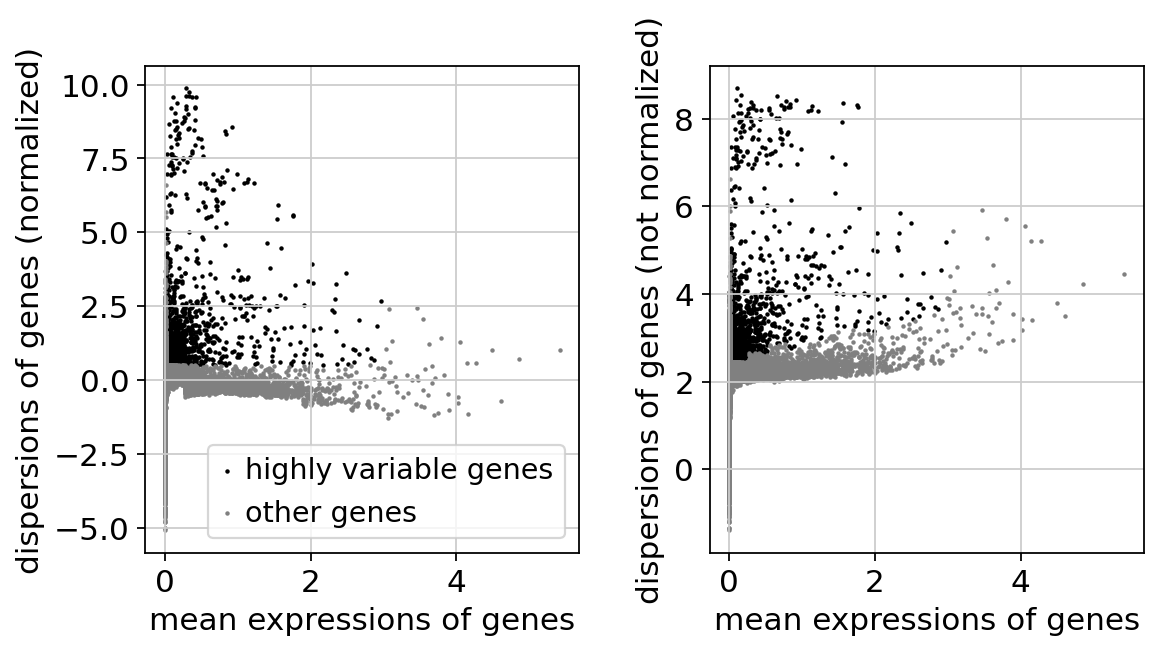

In [6]:
# compute variable genes
sc.pp.highly_variable_genes(combined, min_mean=0.0125, max_mean=3, min_disp=0.5)
print("Highly variable genes: {}".format(sum(combined.var.highly_variable)))

# plot variable genes
sc.pl.highly_variable_genes(combined)

# Only include for variable genes in the dataset
combined = combined[:, combined.var['highly_variable']]

# Mean-centering and Scaling through Z-transformation

In [7]:
# regress out unwanted variables
sc.pp.regress_out(combined, ['n_counts', 'percent_mito'])

# scale data, clip values exceeding standard deviation 10.
sc.pp.scale(combined, max_value=10)

regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use
    finished (0:02:07)


# PCA

In [8]:
sc.tl.pca(combined, svd_solver='arpack',n_comps=100)

computing PCA
    on highly variable genes
    with n_comps=100
    finished (0:00:13)


## Identify the pricipal components

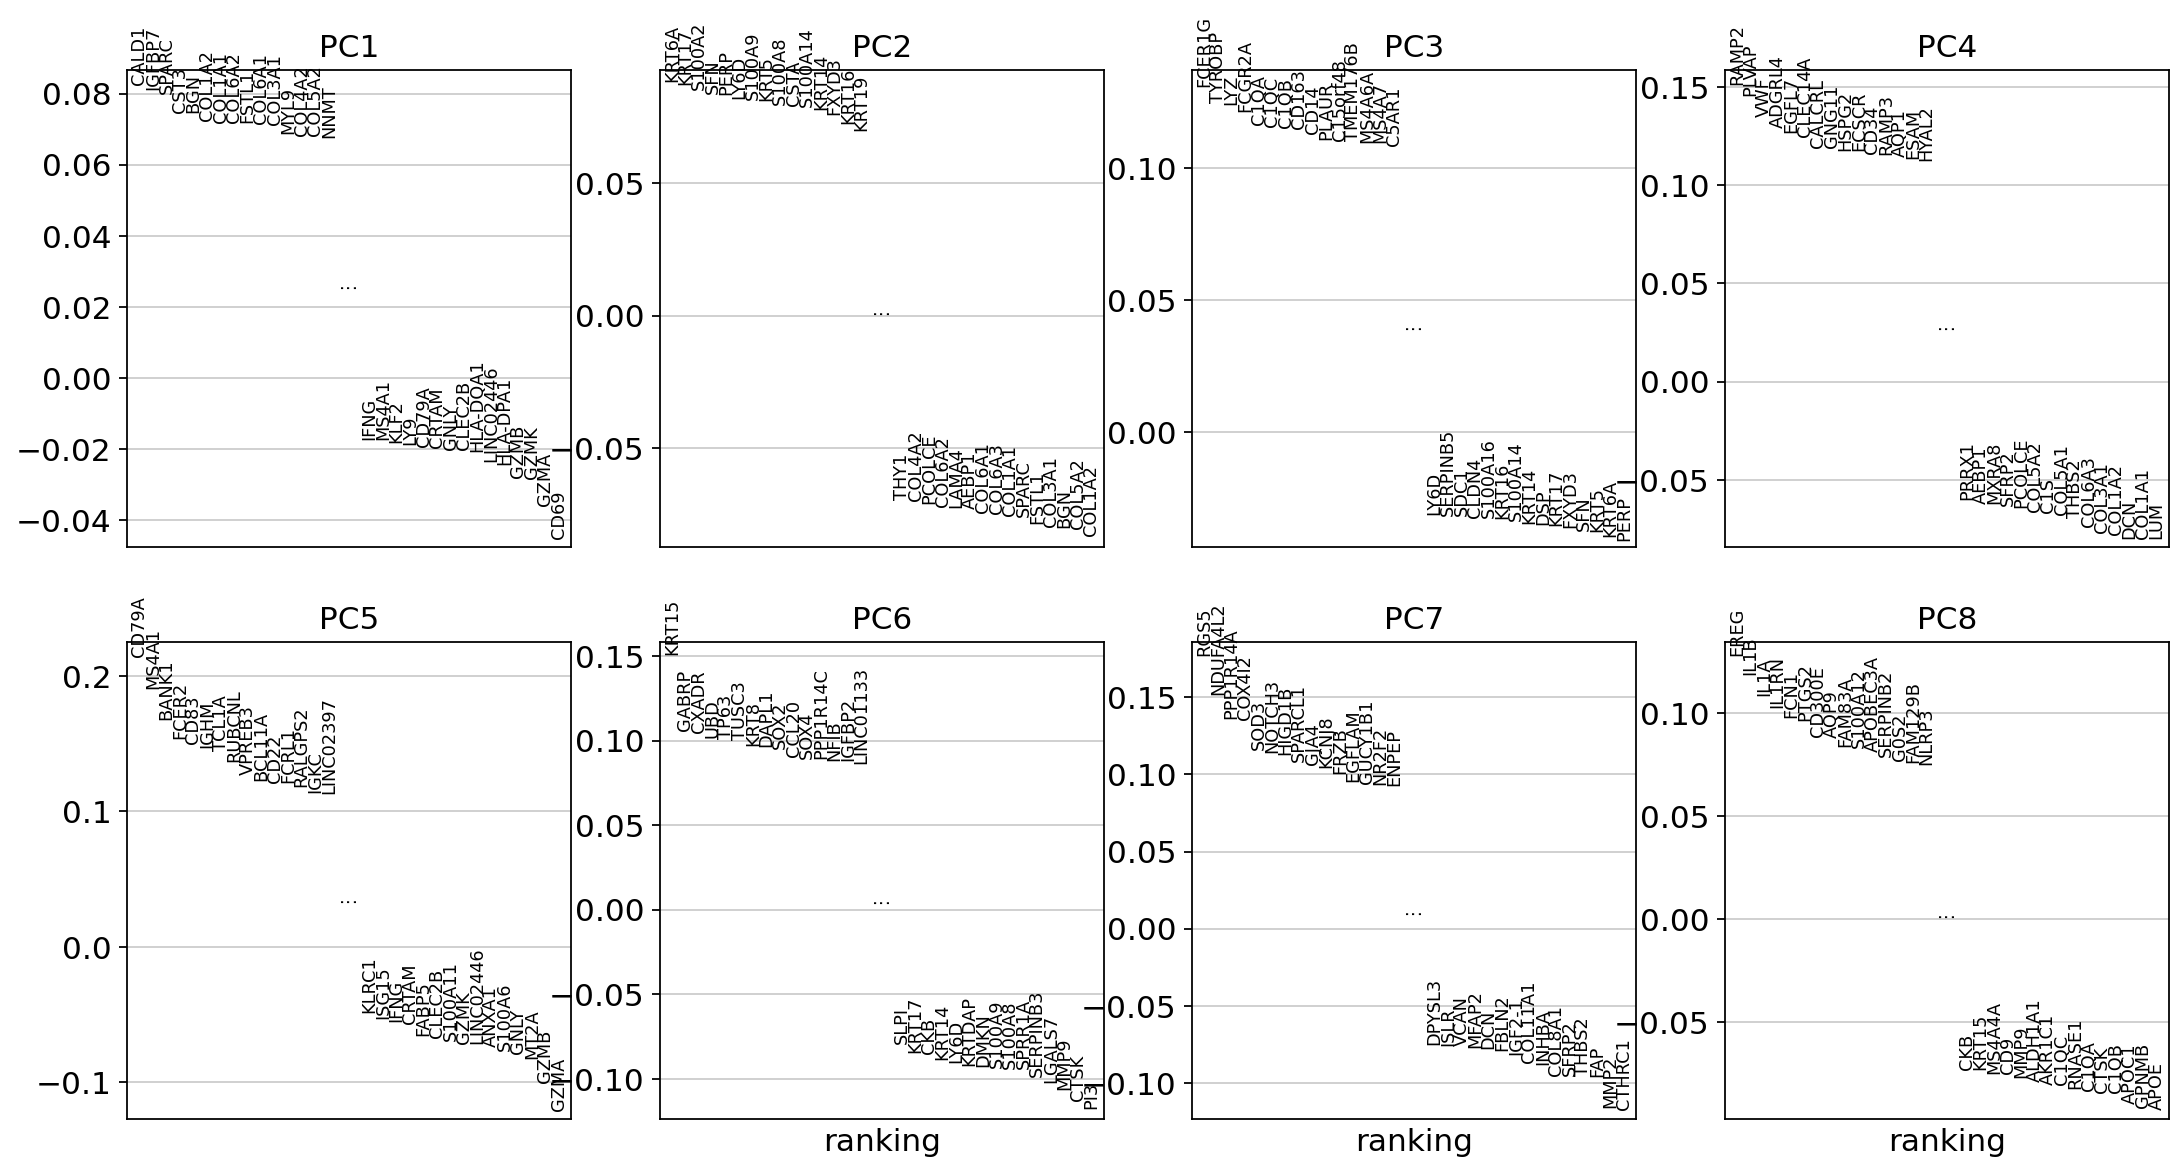

In [9]:
#Plot loadings
sc.pl.pca_loadings(combined, components=[1,2,3,4,5,6,7,8])

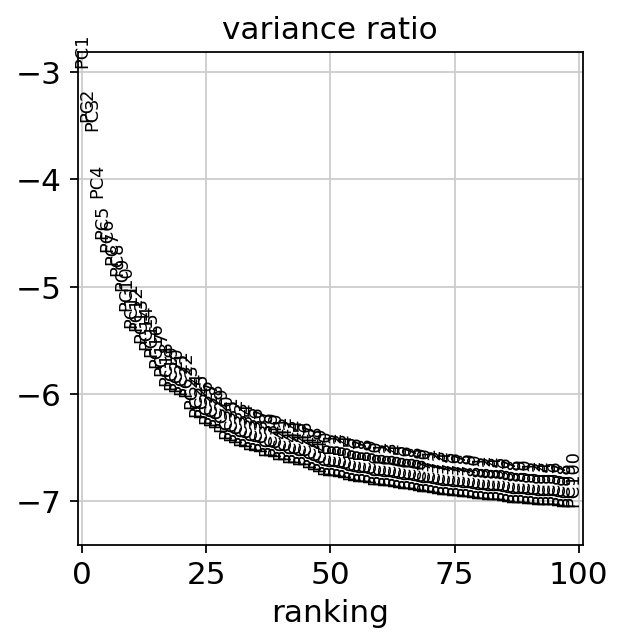

In [10]:
sc.pl.pca_variance_ratio(combined, log=True, n_pcs = 100)

#### Based on the plot, we choose 75 principal components for downstream clustering methods.

# Dimension Reduction by Manifold Embedding

## TSNE 

Run TSNE with the initialization by the first 30 PC's

In [11]:
sc.tl.tsne(combined, n_pcs = 75)

computing tSNE
    using 'X_pca' with n_pcs = 75
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:11:30)


In [29]:
# find marker genes
sc.tl.rank_genes_groups(combined, groupby='louvain', method='t-test')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:10)


## UMAP

#### Since UMAP is built on top of a neighborhood graph, we first compute that with the first 30 PC's. 

In [14]:
sc.pp.neighbors(combined, n_pcs = 30, n_neighbors = 40)

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:52)


In [15]:
# project to a 2-dimensional subspace, save to a new object so that the umap with 2D is not overwritten.
combined_umap = sc.tl.umap(combined, n_components=2, copy=True)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:01:33)


In [24]:
# find marker genes
sc.tl.rank_genes_groups(combined_umap, groupby='leiden', method='t-test')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:11)


## Save Results

In [30]:
# save the tsne clustering output to csv for SCSA annotation
tsne_result = combined.uns['rank_genes_groups']
tsne_clusters = tsne_result['names'].dtype.names
tsne_cluster_data = pd.DataFrame({cluster + '_' + key[:1]: tsne_result[key][cluster] for cluster in tsne_clusters for key in ['names', 'logfoldchanges','scores','pvals']})
tsne_cluster_data.to_csv("/scratch/tsne_cluster.csv") 

In [31]:
# save output for SCSA (an automatic cluster annotation tool)
umap_result = combined_umap.uns['rank_genes_groups']
umap_clusters = umap_result['names'].dtype.names
umap_cluster_data = pd.DataFrame({cluster + '_' + key[:1]: umap_result[key][cluster] for cluster in umap_clusters for key in ['names', 'logfoldchanges','scores','pvals']})
umap_cluster_data.to_csv("/scratch/umap_cluster.csv") 

In [32]:
save_file = '/scratch/combined_tsne.h5ad'
combined.write_h5ad(save_file)

In [33]:
save_file = '/scratch/combined_umap.h5ad'
combined_umap.write_h5ad(save_file)